In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from entsoe import EntsoePandasClient
import cvxpy as cp

# plotting style
sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.autolayout": True})
RNG = np.random.default_rng(42)
pd.options.display.float_format = "{:,.2f}".format


In [2]:
# Paste token here to run the notebook in this session only.
# WARNING: do not commit this cell to version control.
os.environ["ENTSOE_TOKEN"] = "559550e1-666a-4ed4-ae3f-1f157021bc9f"

token = os.getenv("ENTSOE_TOKEN")
if not token:
    raise RuntimeError("Set ENTSOE_TOKEN in this cell or as an OS environment variable.")

client = EntsoePandasClient(api_key=token)
print("ENTSO-E client ready.")


ENTSO-E client ready.


In [3]:
def fetch_hourly_entsoe(zone: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    """
    Fetch hourly day-ahead prices (EUR/MWh) for zone between start and end.
    Splits into <=1-year chunks to respect ENTSO-E limits.
    Returns tz-aware Series in Europe/Berlin.
    """
    tz_api = "Europe/Brussels"  # entsoe-py expects this for calls
    if start.tzinfo is None:
        start = start.tz_localize(tz_api)
    else:
        start = start.tz_convert(tz_api)
    if end.tzinfo is None:
        end = end.tz_localize(tz_api)
    else:
        end = end.tz_convert(tz_api)

    pieces = []
    cursor = start
    one_year = pd.DateOffset(years=1)
    while cursor < end:
        chunk_end = min(cursor + one_year, end)
        s = client.query_day_ahead_prices(zone, start=cursor, end=chunk_end)
        if s is None or len(s) == 0:
            raise RuntimeError(f"ENTSO-E returned no data for {cursor.date()} → {chunk_end.date()}")
        pieces.append(s)
        cursor = chunk_end
    hourly = pd.concat(pieces).sort_index()
    hourly = hourly[~hourly.index.duplicated(keep='first')]
    hourly = hourly.tz_convert("Europe/Berlin")
    return hourly


In [4]:
# Settings: adjust years back if needed
ZONE = "DE_LU"
YEARS_BACK = 3

end = pd.Timestamp.now(tz="Europe/Brussels").normalize() + pd.Timedelta(hours=12)
start = end - pd.DateOffset(years=YEARS_BACK)

print(f"Fetching {ZONE} hourly day-ahead prices from {start.date()} to {end.date()} ...")
prices_hourly = fetch_hourly_entsoe(ZONE, start=start, end=end)
print(f"Hourly rows fetched: {len(prices_hourly):,}")

# Show a small hourly sample
display(prices_hourly.head(8))

# Aggregate to daily average (arithmetic mean) and compute returns
prices_daily = prices_hourly.resample("D").mean().dropna()
returns = prices_daily.pct_change().dropna()

print("\nDaily sample:")
display(prices_daily.head(6))
print("\nDaily returns sample:")
display(returns.head(6))

last_price = float(prices_daily.iloc[-1])
print(f"\nLast daily price (P0): {last_price:.2f} EUR/MWh")


Fetching DE_LU hourly day-ahead prices from 2022-08-16 to 2025-08-16 ...
Hourly rows fetched: 26,305


2022-08-16 12:00:00+02:00   417.08
2022-08-16 13:00:00+02:00   410.06
2022-08-16 14:00:00+02:00   410.09
2022-08-16 15:00:00+02:00   418.06
2022-08-16 16:00:00+02:00   442.53
2022-08-16 17:00:00+02:00   506.91
2022-08-16 18:00:00+02:00   600.05
2022-08-16 19:00:00+02:00   664.89
dtype: float64


Daily sample:


2022-08-16 00:00:00+02:00   522.78
2022-08-17 00:00:00+02:00   551.95
2022-08-18 00:00:00+02:00   563.76
2022-08-19 00:00:00+02:00   515.10
2022-08-20 00:00:00+02:00   457.97
2022-08-21 00:00:00+02:00   364.13
Freq: D, dtype: float64


Daily returns sample:


2022-08-17 00:00:00+02:00    0.06
2022-08-18 00:00:00+02:00    0.02
2022-08-19 00:00:00+02:00   -0.09
2022-08-20 00:00:00+02:00   -0.11
2022-08-21 00:00:00+02:00   -0.20
2022-08-22 00:00:00+02:00    0.55
Freq: D, dtype: float64


Last daily price (P0): 68.64 EUR/MWh


In [5]:
# Example portfolio: net exposures (MWh) per counterparty for next-day exposure
exposures_mwh = {
    "CP_A": 120.0,
    "CP_B": 80.0,
    "CP_C": 30.0,
    "CP_D": 12.0,
    "CP_E": 5.0
}

cp_names = list(exposures_mwh.keys())
q = np.array([exposures_mwh[n] for n in cp_names], dtype=float)  # MWh vector
N = len(cp_names)

print("Counterparty exposures (MWh):")
for k,v in exposures_mwh.items():
    print(f"  {k}: {v:.2f} MWh")
# Define optimization variables
p = cp.Variable(N)  # prices (EUR/MWh)    


Counterparty exposures (MWh):
  CP_A: 120.00 MWh
  CP_B: 80.00 MWh
  CP_C: 30.00 MWh
  CP_D: 12.00 MWh
  CP_E: 5.00 MWh


In [6]:
# Scenario sizes
S_BOOT = 50_000     # bootstrap scenarios for Monte Carlo estimates
S_CVX = 5_000       # smaller S for CVX optimisation (keeps LP manageable)

rets_hist = returns.values.ravel()
if len(rets_hist) < 30:
    raise RuntimeError("Not enough historical returns (need >=30 daily returns).")

# Bootstrap sampling
sampled_rets_boot = RNG.choice(rets_hist, size=S_BOOT, replace=True)
sampled_rets_cvx = RNG.choice(rets_hist, size=S_CVX, replace=True)

# P&L computation:
# P&L_{s,i} = q[i] * last_price * r_s  (positive = gain, negative = loss)
pnl_boot = np.outer(sampled_rets_boot * last_price, q)   # S_BOOT x N
pnl_cvx  = np.outer(sampled_rets_cvx  * last_price, q)   # S_CVX  x N

# Loss matrices (positive numbers representing potential loss)
loss_boot = np.maximum(-pnl_boot, 0.0)   # S_BOOT x N
loss_cvx  = np.maximum(-pnl_cvx, 0.0)    # S_CVX  x N

print(f"Generated {S_BOOT:,} bootstrap scenarios and {S_CVX:,} CVX scenarios.")


Generated 50,000 bootstrap scenarios and 5,000 CVX scenarios.


In [7]:
def var_es_from_pnl_vector(pnl_vec, alpha=0.99):
    q = np.quantile(pnl_vec, 1.0 - alpha)
    var = -q if q < 0 else 0.0
    tail = pnl_vec <= q
    es = -pnl_vec[tail].mean() if np.any(tail) else var
    return float(var), float(es)

alpha = 0.99
rows = []
for i,name in enumerate(cp_names):
    v_hist, e_hist = var_es_from_pnl_vector(pnl_boot[:, i], alpha)
    rows.append({"cp": name, "exposure_mwh": q[i], "var_boot": v_hist, "es_boot": e_hist})

var_df = pd.DataFrame(rows).sort_values("var_boot", ascending=False).reset_index(drop=True)
display(var_df.round(2))


,cp,exposure_mwh,var_boot,es_boot
0,CP_A,120.00,"7,433.94","21,270.27"
1,CP_B,80.00,"4,955.96","14,180.18"
2,CP_C,30.00,"1,858.48","5,317.57"
3,CP_D,12.00,743.39,"2,127.03"
4,CP_E,5.00,309.75,886.26


In [8]:
# Greedy allocation settings
total_budget = 150_000.0  # EUR — edit as desired
step = max(1.0, total_budget / 2000.0)  # resolution of allocation steps (face EUR)

S = loss_boot.shape[0]
loss_mat = loss_boot  # S x N

coll = np.zeros(N)   # face collateral per CP (EUR)
remaining = total_budget
iterations = 0
while remaining >= step:
    # marginal benefit per CP = fraction of scenarios where loss > current collateral
    marginals = np.sum(loss_mat > coll[np.newaxis, :], axis=0) / S
    if np.all(marginals == 0):
        break
    idx = int(np.argmax(marginals))
    coll[idx] += step
    remaining -= step
    iterations += 1
    if iterations > 500_000:
        print("Safety stop: too many iterations.")
        break

greedy_alloc_df = pd.DataFrame({"cp": cp_names, "allocated_face_EUR": coll, "exposure_MWh": q})
total_allocated = coll.sum()
print(f"Greedy allocated (face) = {total_allocated:,.2f} EUR (remaining {remaining:.2f} EUR)")
display(greedy_alloc_df.sort_values("allocated_face_EUR", ascending=False).round(2))


Greedy allocated (face) = 150,000.00 EUR (remaining 0.00 EUR)


,cp,allocated_face_EUR,exposure_MWh
0,CP_A,"132,525.00",120.00
1,CP_B,"10,950.00",80.00
2,CP_C,"4,125.00",30.00
3,CP_D,"1,650.00",12.00
4,CP_E,750.00,5.00


In [9]:
# Collateral types and haircuts
coll_types = ["CASH", "CORP_BOND"]
haircuts = {"CASH": 0.00, "CORP_BOND": 0.05}  # 5% haircut for bond
K = len(coll_types)

# Eligibility map (which CP accepts which type)
elig = {
    "CP_A": {"CASH": True, "CORP_BOND": True},
    "CP_B": {"CASH": True, "CORP_BOND": False},
    "CP_C": {"CASH": True, "CORP_BOND": True},
    "CP_D": {"CASH": True, "CORP_BOND": True},
    "CP_E": {"CASH": True, "CORP_BOND": False},
}
elig_matrix = np.array([[1.0 if elig[name].get(t, False) else 0.0 for t in coll_types] for name in cp_names])

# Budget & caps
budget = total_budget
cap_per_cp = {name: budget for name in cp_names}  # can set per-CP caps here

# Build LP variables
# c_face[i,k] face amount of collateral type k posted to CP i
c = cp.Variable((N, K), nonneg=True)
# u[s,i] residual uncovered loss in scenario s for CP i
S_cvx = loss_cvx.shape[0]
u = cp.Variable((S_cvx, N), nonneg=True)

# effective collateral per cp: eff_i = sum_k elig[i,k]* (1 - haircut_k) * c[i,k]
haircut_vec = np.array([haircuts[t] for t in coll_types])
# form linear expressions
elig_matrix = elig_matrix.astype(float)  # ensure float
eff_per_cp = cp.sum(cp.multiply(cp.multiply(c, (1.0 - haircut_vec)[None, :]), elig_matrix), axis=1)

# Constraints:
constraints = []
# residuals constraints across scenarios
for s in range(S_cvx):
    constraints.append(u[s, :] >= loss_cvx[s, :] - eff_per_cp)
# budget constraint (face values)
constraints.append(cp.sum(c) <= budget)
# caps per cp (face)
for i,name in enumerate(cp_names):
    constraints.append(cp.sum(c[i, :]) <= cap_per_cp[name])

# Objective: minimise average residual uncovered loss across scenarios
objective = cp.Minimize(cp.sum(u) / S_cvx)
prob = cp.Problem(objective, constraints)

print("Solving CVX LP (this may take a few seconds)...")
prob.solve(solver=cp.SCS, verbose=False)
print("Solver status:", prob.status)

# Extract solution
c_opt = c.value  # N x K
face_alloc_per_cp = np.sum(c_opt, axis=1)
eff_coll_per_cp = np.sum(c_opt * (1.0 - haircut_vec)[None, :] * elig_matrix, axis=1)

cvx_alloc_df = pd.DataFrame({
    "cp": cp_names,
    "face_alloc_total_EUR": face_alloc_per_cp,
    "effective_coll_EUR": eff_coll_per_cp,
    "exposure_MWh": q
})
for idx, t in enumerate(coll_types):
    cvx_alloc_df[f"alloc_{t}_face_EUR"] = c_opt[:, idx]
display(cvx_alloc_df.round(2))


Solving CVX LP (this may take a few seconds)...


c:\Users\POSTE\anaconda3\Lib\site-packages\scs\__init__.py:96: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


Solver status: optimal_inaccurate


c:\Users\POSTE\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,cp,face_alloc_total_EUR,effective_coll_EUR,exposure_MWh,alloc_CASH_face_EUR,alloc_CORP_BOND_face_EUR
0,CP_A,"105,566.52","103,702.94",120.00,"68,294.74","37,271.78"
1,CP_B,"323,473.39","323,473.39",80.00,"323,473.39",0.00
2,CP_C,"106,791.07","104,888.06",30.00,"68,730.92","38,060.15"
3,CP_D,"106,731.98","104,790.97",12.00,"67,911.71","38,820.27"
4,CP_E,"326,888.43","326,888.43",5.00,"326,888.43",0.00


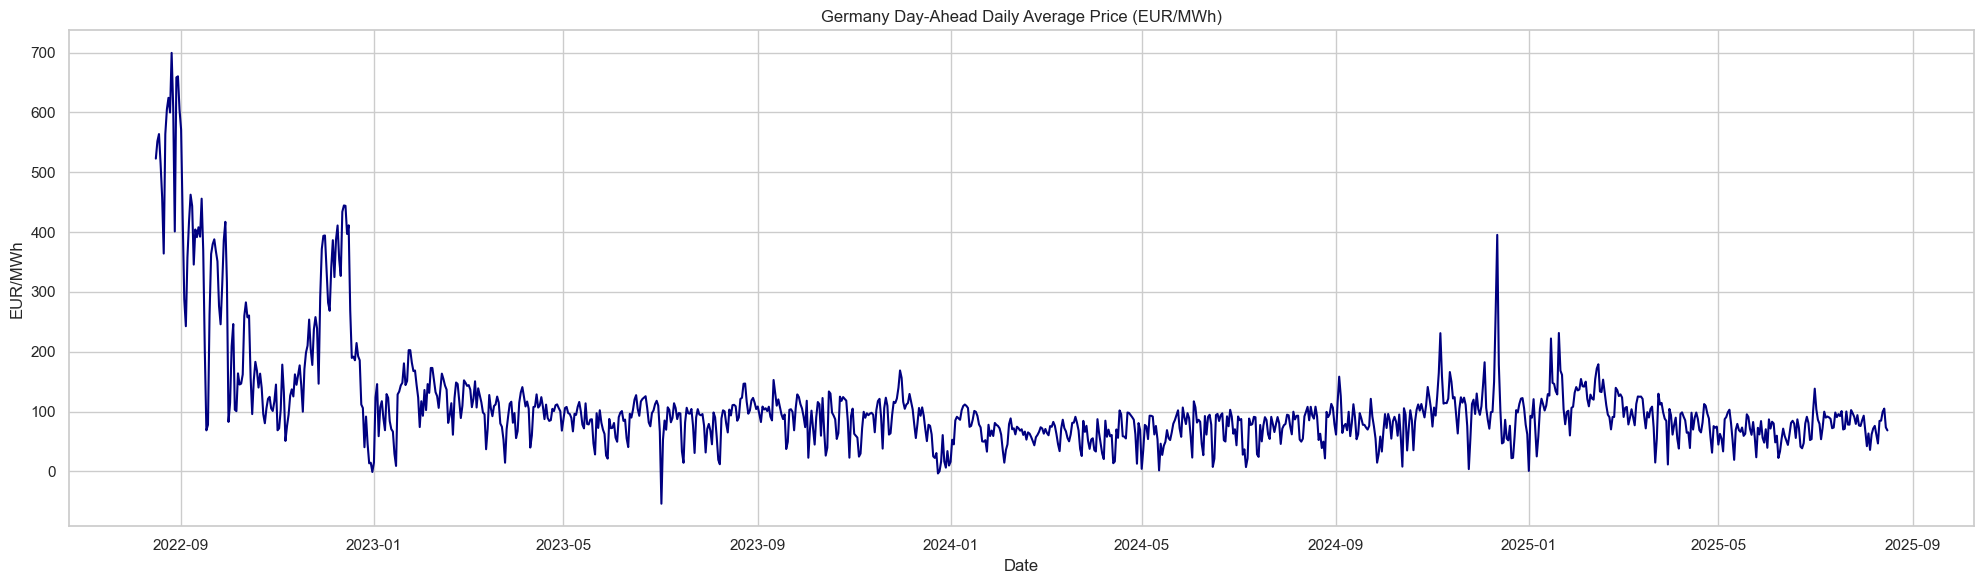

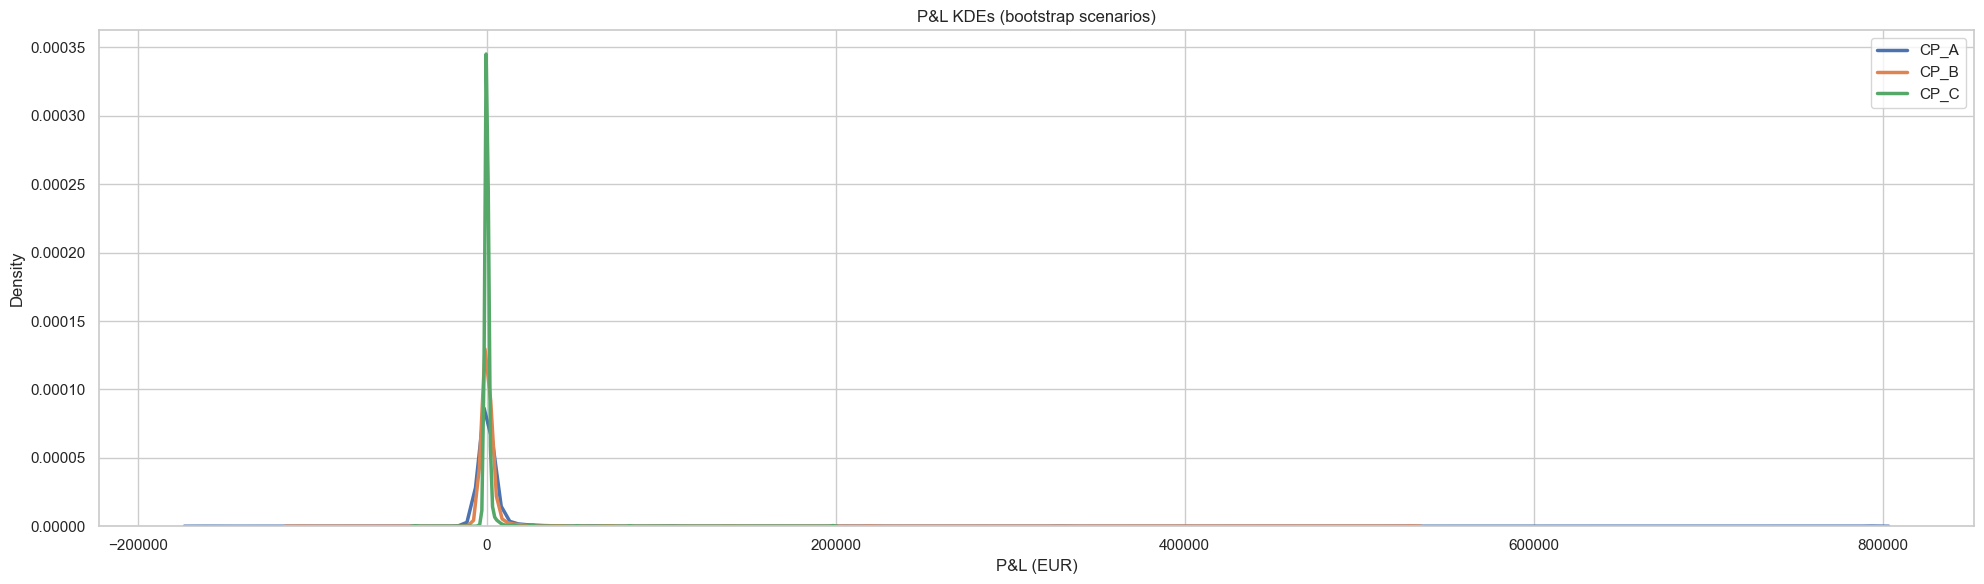

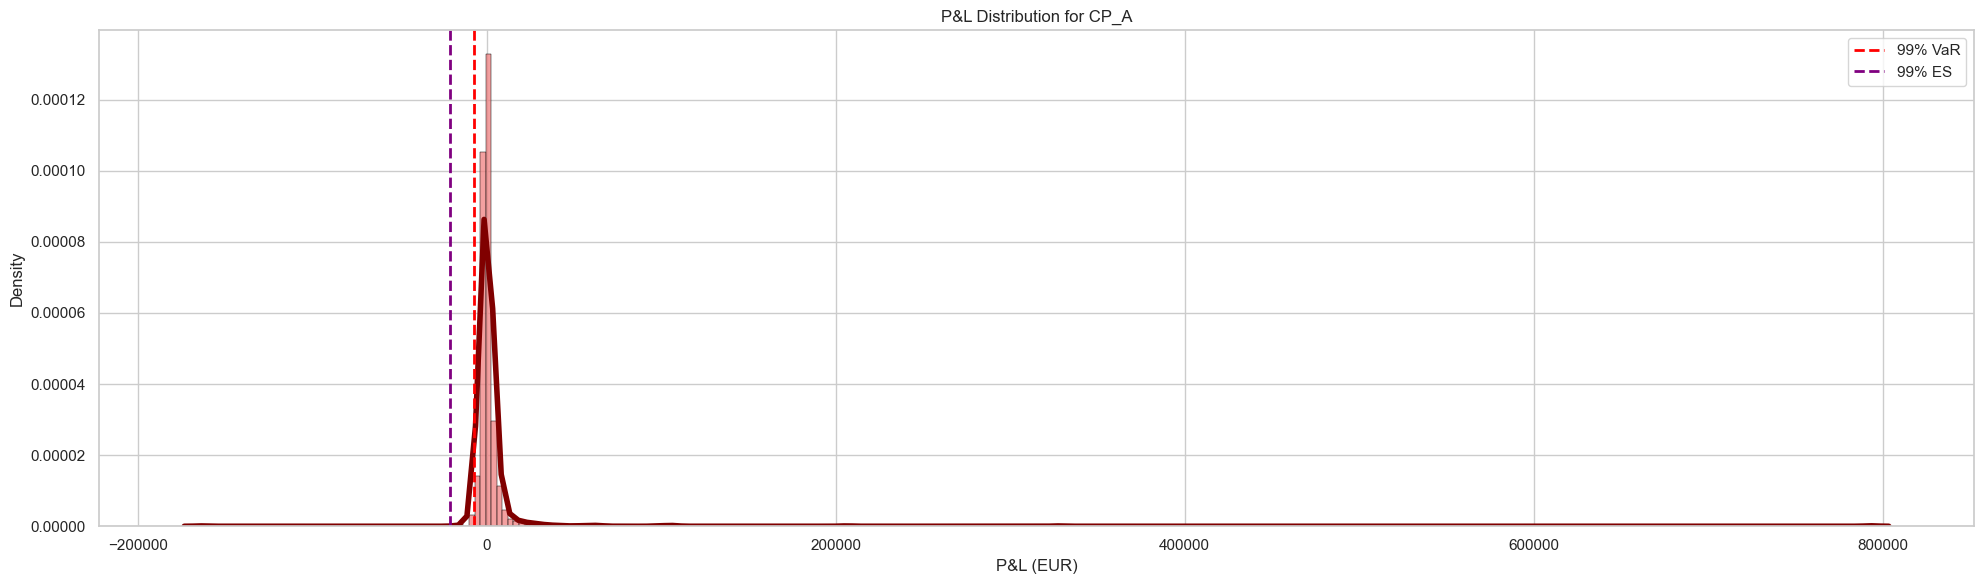

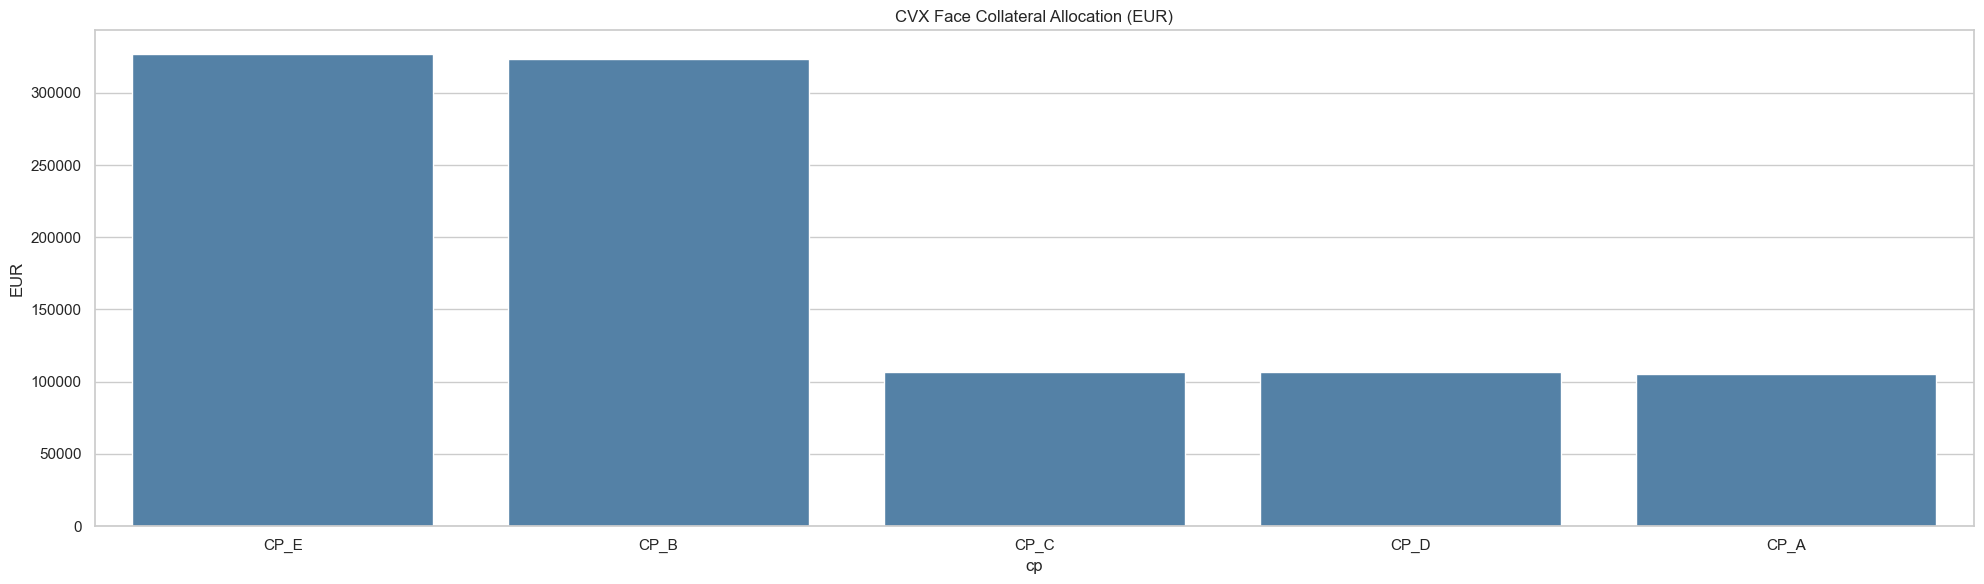

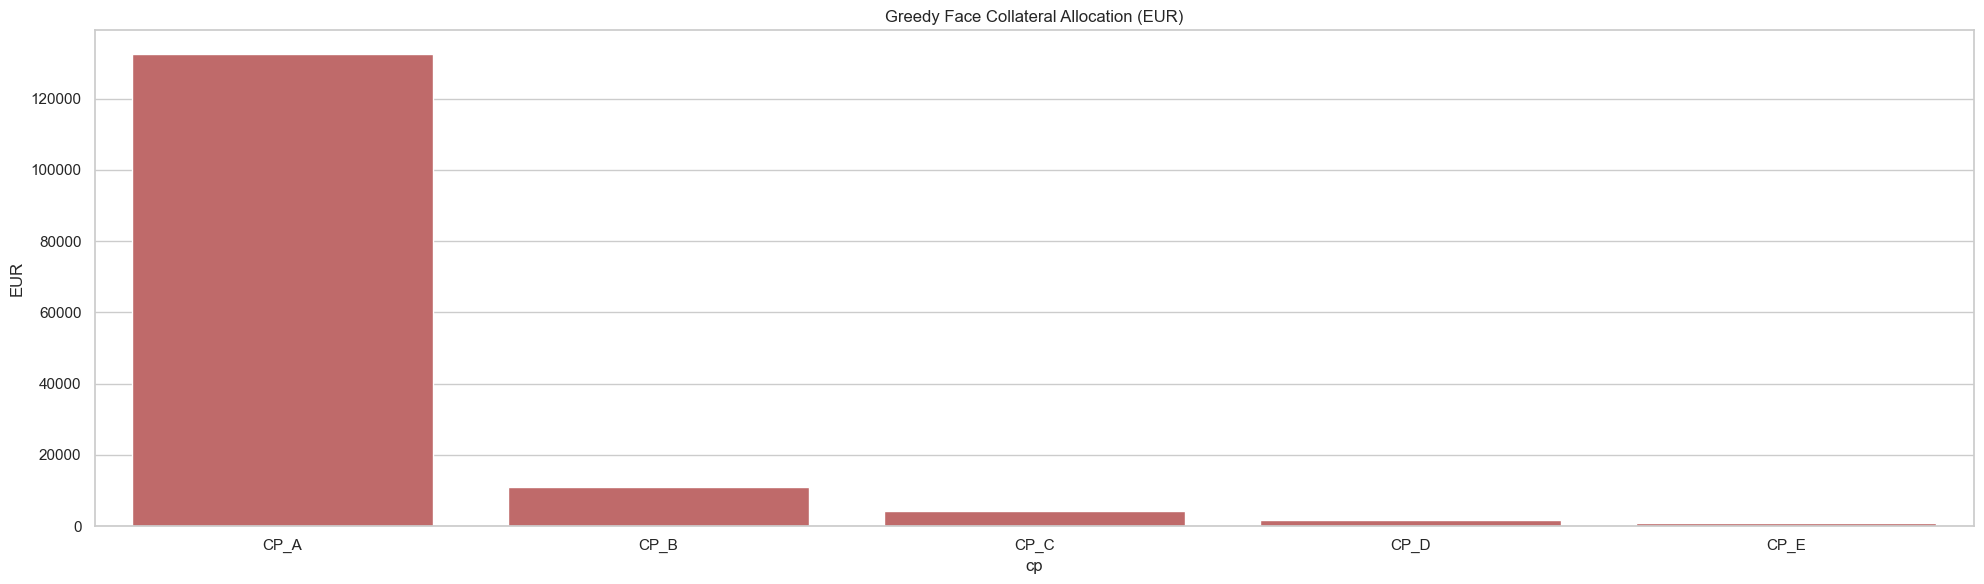

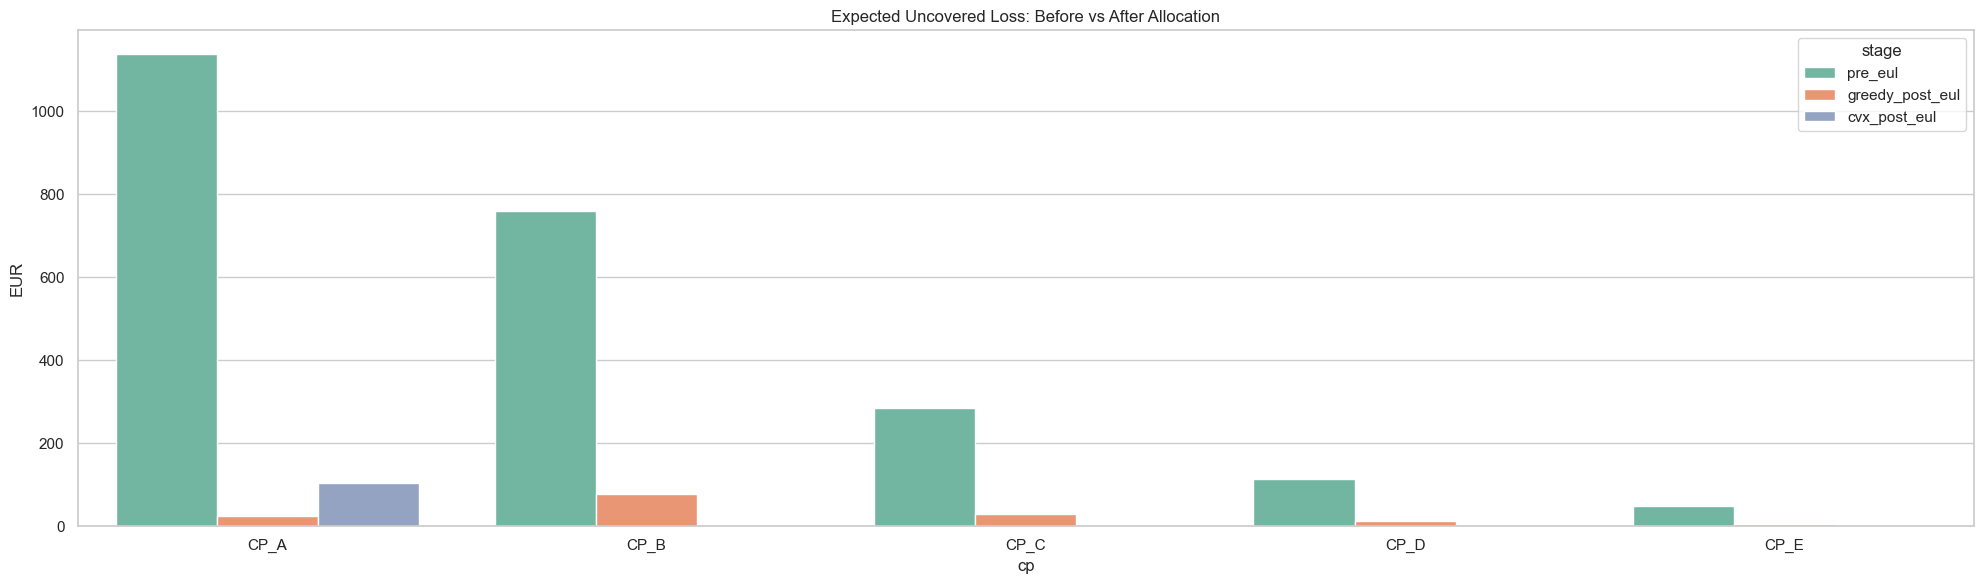

In [ ]:
# Prices time series
plt.figure(figsize=(20,6))
sns.lineplot(x=prices_daily.index, y=prices_daily.values, linewidth=1.5, color='navy')
plt.title("Germany Day-Ahead Daily Average Price (EUR/MWh)")
plt.xlabel("Date")
plt.ylabel("EUR/MWh")
plt.show()



# P&L KDEs for top 3 counterparties
top3 = var_df['cp'].iloc[:3].tolist()
plt.figure(figsize=(20,6))
for name in top3:
    idx = cp_names.index(name)
    sns.kdeplot(pnl_boot[:, idx], linewidth=2.5, label=name)
plt.title("P&L KDEs (bootstrap scenarios)")
plt.xlabel("P&L (EUR)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Single CP P&L histogram + KDE (most risky)
top_cp = var_df['cp'].iloc[0]
top_idx = cp_names.index(top_cp)
plt.figure(figsize=(20,6))
sns.histplot(pnl_boot[:, top_idx], bins=300, stat='density', color='lightcoral', edgecolor='black', alpha=0.75)
sns.kdeplot(pnl_boot[:, top_idx], linewidth=4, color='maroon')
plt.axvline(-var_df.loc[var_df['cp']==top_cp,'var_boot'].values[0], color='red', linestyle='--', linewidth=2, label='99% VaR')
plt.axvline(-var_df.loc[var_df['cp']==top_cp,'es_boot'].values[0], color='purple', linestyle='--', linewidth=2, label='99% ES')
plt.title(f"P&L Distribution for {top_cp}")
plt.xlabel("P&L (EUR)")
plt.ylabel("Density")
plt.legend()
plt.show()

# CVX allocation barplot
plt.figure(figsize=(20,6))
tmp = cvx_alloc_df.copy().sort_values("face_alloc_total_EUR", ascending=False)
sns.barplot(x="cp", y="face_alloc_total_EUR", data=tmp, color='steelblue')
plt.title("CVX Face Collateral Allocation (EUR)")
plt.ylabel("EUR")
plt.show()

# Greedy allocation barplot
plt.figure(figsize=(20,6))
tmp2 = greedy_alloc_df.copy().sort_values("allocated_face_EUR", ascending=False)
sns.barplot(x="cp", y="allocated_face_EUR", data=tmp2, color='indianred')
plt.title("Greedy Face Collateral Allocation (EUR)")
plt.ylabel("EUR")
plt.show()

# Pre vs post EUL comparison

# Pre-allocation EUL (mean loss per CP, no collateral)
eul_pre = loss_boot.mean(axis=0)

# Greedy allocation EUL (mean loss per CP after greedy collateral)
eul_greedy = np.maximum(loss_boot - greedy_alloc_df["allocated_face_EUR"].values, 0).mean(axis=0)

# CVX allocation EUL (mean loss per CP after cvx collateral, use loss_cvx and cvx_alloc_df)
cvx_face = cvx_alloc_df["face_alloc_total_EUR"].values
eul_cvx = np.maximum(loss_cvx - cvx_face, 0).mean(axis=0)

# Create summary DataFrame
summary = pd.DataFrame({
    "cp": cp_names,
    "pre_eul": eul_pre,
    "greedy_post_eul": eul_greedy,
    "cvx_post_eul": eul_cvx
})

plt.figure(figsize=(20,6))
summary_plot = summary.melt(
    id_vars="cp",
    value_vars=["pre_eul","greedy_post_eul","cvx_post_eul"],
    var_name="stage",
    value_name="EUL"
)
sns.barplot(x="cp", y="EUL", hue="stage", data=summary_plot, palette='Set2')
plt.title("Expected Uncovered Loss: Before vs After Allocation")
plt.ylabel("EUR")
plt.show()


